In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 67.6 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import os
from transformers import BertConfig, BertTokenizer
from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,RandomSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import pickle
from sklearn.metrics import classification_report
import seaborn as sns
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
x_train_df = pd.read_csv('/content/drive/MyDrive/datas/x_train.csv')
x_test_df = pd.read_csv('/content/drive/MyDrive/datas/x_test.csv')
x_dev_df = pd.read_csv('/content/drive/MyDrive/datas/x_dev.csv')
y_train_df = pd.read_csv('/content/drive/MyDrive/datas/y_train.csv')
y_test_df = pd.read_csv('/content/drive/MyDrive/datas/y_test.csv')
y_dev_df = pd.read_csv('/content/drive/MyDrive/datas/y_dev.csv')

In [ ]:
x_train = x_train_df.doc.values
x_test = x_test_df.doc.values
x_dev = x_dev_df.doc.values
y_train = y_train_df.label.values
y_test = y_test_df.label.values
y_dev = y_dev_df.label.values

In [ ]:
max_len = 512
train_batch_size = 16
dev_batch_size = 16
test_batch_size = 16

epochs = 3



MODEL_NAME = 'HooshvareLab/bert-fa-base-uncased-clf-persiannews'
# OUTPUT_PATH = '/content/bert/trained_model.bin'

# os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {'Economic': 1, 'International': 0, 'Political': 5,'Science Technology': 3,'Cultural Art': 4,'Sport':6,"Social":2}
id2label = {0:'International',1:'Economic',2:'Social',3:'Science Technology',4:'Cultural Art',5:'Political',6:'Sport'}

In [ ]:
config = BertConfig.from_pretrained(MODEL_NAME, **{ 'label2id': label2id,'id2label': id2label})

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

In [ ]:
x_train_df['doc'][:5]

0    معاون استاندار قم بهترین فیلم های جشنواره فجر ...
1    علی محمد چهارمحالی اظهار کرد برای دومین بار مت...
2    سردار سیدصادق حسینی صبح امروز در نشست خبری با ...
3    قرعه کشی فروش فوق العاده محصول سایپا در هفته س...
4    رییس جمهور گفت بین دولت دانشگاه فاصله ای نباید...
Name: doc, dtype: object

In [ ]:
dic={}
for i in range(len(x_train)):
  if (len(str(x_train[i]))) not in dic:
     dic[len(str(x_train[i]))]=1
  else:
    dic[len(str(x_train[i]))]+=1   

for i in range(len(x_test)):
  if (len(str(x_test[i]))) not in dic:
     dic[len(str(x_test[i]))]=1
  else:
    dic[len(str(x_test[i]))]+=1  

for i in range(len(x_dev)):
  if (len(str(x_dev[i]))) not in dic:
     dic[len(str(x_dev[i]))]=1
  else:
    dic[len(str(x_dev[i]))]+=1  


In [ ]:
{k: v for k, v in sorted(dic.items(), key=lambda item: item[1],reverse=True)}

{25: 56,
 2: 45,
 6: 35,
 13: 35,
 803: 33,
 332: 31,
 12: 26,
 756: 26,
 26: 26,
 1014: 25,
 733: 24,
 11: 24,
 796: 23,
 660: 23,
 709: 23,
 859: 23,
 719: 23,
 741: 23,
 752: 22,
 892: 22,
 821: 22,
 824: 22,
 1013: 22,
 5: 22,
 384: 21,
 677: 21,
 843: 21,
 745: 21,
 1069: 21,
 572: 21,
 735: 21,
 617: 21,
 726: 21,
 878: 21,
 826: 21,
 662: 21,
 811: 21,
 664: 20,
 624: 20,
 459: 20,
 839: 20,
 732: 20,
 870: 20,
 10: 20,
 991: 20,
 728: 20,
 694: 20,
 863: 20,
 883: 20,
 979: 20,
 698: 20,
 849: 20,
 674: 20,
 569: 20,
 800: 20,
 568: 20,
 582: 20,
 977: 20,
 1081: 20,
 590: 19,
 744: 19,
 370: 19,
 672: 19,
 1337: 19,
 1868: 19,
 770: 19,
 577: 19,
 851: 19,
 1128: 19,
 761: 19,
 633: 19,
 680: 19,
 970: 19,
 634: 19,
 546: 19,
 1102: 19,
 865: 19,
 504: 19,
 917: 19,
 854: 19,
 717: 19,
 1055: 19,
 1182: 18,
 783: 18,
 578: 18,
 1240: 18,
 636: 18,
 554: 18,
 740: 18,
 809: 18,
 1277: 18,
 640: 18,
 620: 18,
 940: 18,
 869: 18,
 1030: 18,
 483: 18,
 778: 18,
 1380: 18,
 491: 18

In [ ]:
print(x_train[0])
print(tokenizer.tokenize(x_train[0]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x_train[0])))

معاون استاندار قم بهترین فیلم های جشنواره فجر در قم اکران می شود ایسناقم معاون هماهنگی امور زایران استانداری قم گفت فیلم های انتخاب شده برای اکران در این استان جز بهترین فیلم های جشنواره فجر است ابوالقاسم مقیمی در حاشیه اکران فیلم های جشنواره فجر در سینما ونوس قم با اشاره به اینکه چهلمین جشنواره فیلم فجر رویداد متفاوتی از جشنواره های دوره های قبل است اظهار کرد در این دوره فیلمسازان جوان با انگیزه انقلابی ورود کرده اند همچنین تولید اثار با رویکردهای جدیدی همچون انقلاب اسلامی شخصیت ها شهدا فیلم هایی که محتوایی مردمی تر را در خود دارند از رخدادهای ویژه جشنواره سالجاری است وی ادامه داد امسال از حاشیه های مختلف جشنواره کم شده بیشتر به متن محتوایی ان پرداخته می شود که از دیگر اتفاقات خوب جشنواره است مقیمی با اشاره به برگزاری خوب اطلاع رسانی مناسب اداره کل فرهنگ ارشاد اسلامی برای این رخداد بزرگ هنری فرهنگی خاطرنشان کرد امیدواریم این جشنواره با استقبال خوب شهروندان با رعایت پروتکل های بهداشتی همراه باشد این استقبال مناسبی که در روز اول شاهد بودیم تا روز اخر ادامه پیدا کند بر اساس اعلام دفتر سی

In [ ]:
encoded_x_train=[]
mask_x_train=[]
for sent in x_train:
  encoded_dic = tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len, pad_to_max_length = True,truncation=True, return_attention_mask = True, return_tensors = 'pt')
  encoded_x_train.append(encoded_dic['input_ids'])
  mask_x_train.append(encoded_dic['attention_mask'])

encoded_x_train = torch.cat(encoded_x_train, dim=0)
mask_x_train = torch.cat(mask_x_train, dim=0)
y_train = torch.tensor(y_train)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_x_test=[]
mask_x_test=[]
for sent in x_test:
  encoded_dic = tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len,truncation=True, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
  encoded_x_test.append(encoded_dic['input_ids'])
  mask_x_test.append(encoded_dic['attention_mask'])

encoded_x_test = torch.cat(encoded_x_test, dim=0)
mask_x_test = torch.cat(mask_x_test, dim=0)
y_test = torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_x_dev=[]
mask_x_dev=[]
for sent in x_dev:
  encoded_dic = tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
  encoded_x_dev.append(encoded_dic['input_ids'])
  mask_x_dev.append(encoded_dic['attention_mask'])

encoded_x_dev = torch.cat(encoded_x_dev, dim=0)
mask_x_dev = torch.cat(mask_x_dev, dim=0)
y_dev = torch.tensor(y_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(encoded_x_train.shape)
print(encoded_x_test.shape)
print(encoded_x_dev.shape)
print(y_train.shape)
print(y_test.shape)
print(y_dev.shape)

torch.Size([20479, 512])
torch.Size([4389, 512])
torch.Size([4389, 512])
torch.Size([20479])
torch.Size([4389])
torch.Size([4389])


In [ ]:
train_dataset = TensorDataset(encoded_x_train, mask_x_train, y_train)
test_dataset = TensorDataset(encoded_x_test, mask_x_test, y_test)
dev_dataset = TensorDataset(encoded_x_dev, mask_x_dev, y_dev)

In [ ]:
train_batch = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = train_batch_size)
test_batch = DataLoader(test_dataset, sampler = RandomSampler(test_dataset), batch_size = test_batch_size)
dev_batch = DataLoader(dev_dataset, sampler = RandomSampler(dev_dataset), batch_size = dev_batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME,config=config,ignore_mismatched_sizes=True)
model.cuda()

Downloading:   0%|          | 0.00/621M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased-clf-persiannews and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([8, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([8]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
total_steps = len(train_batch) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps = total_steps)

In [ ]:
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

In [ ]:


training_stats = []

for epoch_i in range(0, epochs):


    print(' Epoch {:} / {:} '.format(epoch_i + 1, epochs))
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_batch):

        encoded_batch_x_train = batch[0].to(device)
        mask_batch_x_train = batch[1].to(device)
        labels_batch_x_train = batch[2].to(device)
        model.zero_grad()        
        result = model(encoded_batch_x_train, 
                       token_type_ids=None, 
                       attention_mask=mask_batch_x_train, 
                       labels=labels_batch_x_train,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_batch)            
    print("  Average training loss: {0:.2f}".format(avg_train_loss))  

    print("Running Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in dev_batch:
        encoded_batch_x_dev = batch[0].to(device)
        mask_batch_x_dev = batch[1].to(device)
        labels_batch_x_dev = batch[2].to(device)
        with torch.no_grad():        
            result = model(encoded_batch_x_dev, 
                           token_type_ids=None, 
                           attention_mask=mask_batch_x_dev,
                           labels=labels_batch_x_dev,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels_batch_x_dev.to('cpu').numpy()


        total_eval_accuracy += accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(dev_batch)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_batch)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )

print("")
print("Training complete!")

 Epoch 1 / 3 
  Average training loss: 0.58
Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.49
 Epoch 2 / 3 
  Average training loss: 0.33
Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.45
 Epoch 3 / 3 
  Average training loss: 0.20
Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.51

Training complete!


In [ ]:
filename = 'bert_model.pt'
torch.save(model, filename)

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.580981,0.489328,0.839273
2,0.334101,0.452249,0.858318
3,0.198746,0.512189,0.865864


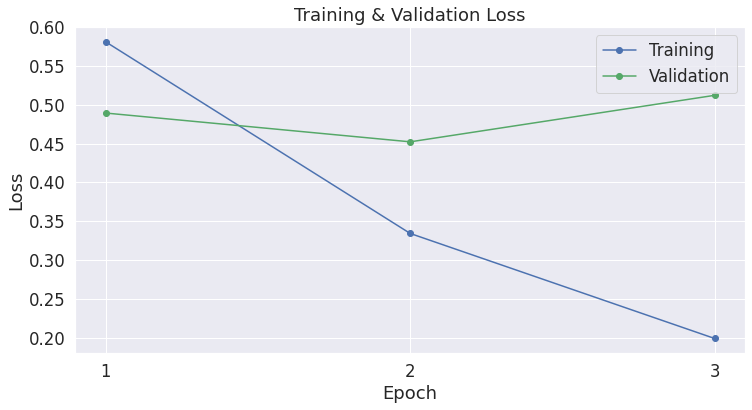

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [ ]:
model.eval()
predictions , true_labels = [], []
for batch in test_batch:

  batch = tuple(t.to(device) for t in batch)
  encoded_batch_x_test, mask_batch_x_test, labels_batch_x_test = batch
  with torch.no_grad():
      result = model(encoded_batch_x_test, 
                     token_type_ids=None, 
                     attention_mask=mask_batch_x_test,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids =labels_batch_x_test .to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
np.argmax(predictions[0], axis=1)

array([5, 6, 4, 6, 6, 5, 3, 5, 0, 0, 0, 0, 5, 2, 5, 6])

In [ ]:
true_labels[1]

array([6, 0, 6, 0, 0, 4, 3, 5, 5, 3, 1, 6, 6, 0, 1, 1])

In [ ]:
predicts = []
t_labels = []
for i in range(len(true_labels)):
    t_labels.extend(true_labels[i])
    predict_label = np.argmax(predictions[i], axis=1).tolist()
    predicts.extend(predict_label)

In [ ]:
target_name = ['beinolmelal', 'eghtesadi', 'ejtemaee', 'elmivadaneshghai', 'farhanghonarvaresane', 'siasi', 'varzeshi']
print(classification_report(t_labels, predicts, target_names = target_name))

                      precision    recall  f1-score   support

         beinolmelal       0.88      0.91      0.89       776
           eghtesadi       0.88      0.81      0.84       601
            ejtemaee       0.78      0.82      0.80       593
    elmivadaneshghai       0.83      0.85      0.84       575
farhanghonarvaresane       0.87      0.84      0.85       514
               siasi       0.79      0.81      0.80       567
            varzeshi       0.97      0.95      0.96       763

            accuracy                           0.86      4389
           macro avg       0.86      0.85      0.86      4389
        weighted avg       0.86      0.86      0.86      4389



In [ ]:
bert_model=torch.load('/content/drive/MyDrive/model/bert_model.pt')

In [ ]:
dicconvert = {
            'ك': 'ک',
            'دِ': 'د',
            'بِ': 'ب',
            'زِ': 'ز',
            'ذِ': 'ذ',
            'شِ': 'ش',
            'سِ': 'س',
            'ى': 'ی',
            'ي': 'ی',
            '١': '۱',
            '٢': '۲',
            '٣': '۳',
            '٤': '۴',
            '٥': '۵',
            '٦': '۶',
            '٧': '۷',
            '٨': '۸',
            '٩': '۹',
            '٠': '۰',
        }
numbers = "۰۱۲۳۴۵۶۷۸۹" + "0123456789"



In [ ]:
doc="""
با توجه به اینکه بی حجابی در جامعه اسلامی به اوج خود رسیده است و هنگامی که به این افراد در مورد پوشش بدشان تذکر داده می شود اکثرا فحاشی کرده و در مواردی که مشاهده شده آمرین به معروف را مورد حمله فیزیکی قرار می دهند درخواست داریم در مکان‌های دولتی به خانم‌های بدحجاب و آقایان با پوششهای زننده خدماتی ارائه نشود.
"""

In [ ]:
sentence=[]
contents = ""

for word in doc.split():
    
    word = "".join([w if w not in dicconvert else dicconvert[w] for w in word])
    word = "".join([w for w in word if w not in numbers])
    word = re.sub(r'[^\w\s]', '', word)
    word = re.sub("[a-zA-Z]+", "", word)
    word = word.strip()
    if (word != "") and (len(word) > 1):
        sentence.append(word)

contents=" ".join(sentence)

In [ ]:
contents

'با توجه به اینکه بی حجابی در جامعه اسلامی به اوج خود رسیده است هنگامی که به این افراد در مورد پوشش بدشان تذکر داده می شود اکثرا فحاشی کرده در مواردی که مشاهده شده آمرین به معروف را مورد حمله فیزیکی قرار می دهند درخواست داریم در مکانهای دولتی به خانمهای بدحجاب آقایان با پوششهای زننده خدماتی ارائه نشود'

In [ ]:
encoded_test_doc=[]
mask_test_doc=[]

encoded_dic = tokenizer.encode_plus(contents, add_special_tokens = True, max_length = max_len,truncation=True, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
encoded_test_doc.append(encoded_dic['input_ids'])
mask_test_doc.append(encoded_dic['attention_mask'])

encoded_test_doc = torch.cat(encoded_test_doc, dim=0)
mask_test_doc = torch.cat(mask_test_doc, dim=0)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_test_doc

tensor([[    2,  2799,  3211,  2789,  3131,  2883, 39581,  2786,  3780,  3449,
          2789,  6571,  2847,  4583,  2806,  4994,  2800,  2789,  2802,  3440,
          2786,  3050,  5032, 23383, 12345,  3171,  2793,  3073, 12313, 31583,
          3027,  2786,  6316,  2800,  4482,  2871, 79493,  2789,  4387,  2803,
          3050,  4218,  6292,  2959,  2793,  4577,  4905,  4314,  2786,  8528,
          4433,  2789, 21271, 69874,  9476,  2799, 17386, 23004, 10217,  3625,
          6062,     4,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
bert_model.eval()
predictions = []

encoded_doc = encoded_test_doc.to(device)
mask_doc = mask_test_doc.to(device)
with torch.no_grad():
  result = bert_model(encoded_doc, 
                     token_type_ids=None, 
                     attention_mask=mask_doc,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  predictions.append(logits)

print('    DONE.')

    DONE.


In [ ]:
predict_label_doc = np.argmax(predictions[0], axis=1).tolist()

In [ ]:
predict_label_doc

[2]